## VGG16 Face

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### prepare Data

In [7]:
BASE_DIR = os.path.abspath(os.getcwd())
train_dir = os.path.join(BASE_DIR+'\stroke-normal_dataset_processed\Train')
val_dir = os.path.join(BASE_DIR+'\stroke-normal_dataset_processed\Test')

NUM_OF_TRAIN_SAMPLES = 1844 
NUM_OF_VAL_SAMPLES = 4171 
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 20,
                                    horizontal_flip = True,
                                    fill_mode = 'wrap')

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

Found 1844 images belonging to 2 classes.
Found 4171 images belonging to 2 classes.


In [8]:
for class_name in os.listdir(train_dir):
    class_len = len(os.listdir(os.path.join(train_dir,class_name)))
    print("class "+class_name+f" has {class_len} data for training")

class droopy has 922 data for training
class normal has 922 data for training


### extract

1/1 [==============================] - 0s 187ms/step


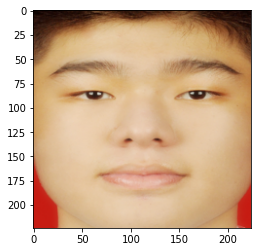

In [9]:
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = cv2.imread(filename, cv2.COLOR_BGR2RGB)
	pixels = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	return image

# load the photo and extract the face
face_extract = extract_face('3F19DDAA-41C3-47B9-94DF-6BDBFC106751.jpg')
# plot the extracted face
pyplot.imshow(face_extract)
# show the plot
pyplot.show()


### preprocessing

In [25]:
CHANNELS = 3
HEIGHT = 224
WIDTH = 224
def prepareImg(fileitem):
    try:
        img = extract_face(fileitem)
        image_resized = tf.image.resize(img, [HEIGHT, WIDTH])
        image_normalized = image_resized / 255.0
        image_for_model = np.expand_dims(image_normalized, axis=0)
    except:
        im = cv2.imread(fileitem)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        image_resized = tf.image.resize(im, [HEIGHT, WIDTH])
        image_normalized = image_resized / 255.0
        image_for_model = np.expand_dims(image_normalized, axis=0)
    return image_for_model

def prepareDataset(fileitem):
    im = cv2.imread(fileitem)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image_resized = tf.image.resize(im, [HEIGHT, WIDTH])
    image_normalized = image_resized / 255.0
    image_for_model = np.expand_dims(image_normalized, axis=0)
    return image_for_model


### create model

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [49]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 
pre_trained_model = tf.keras.applications.MobileNetV2(weights='imagenet', 
                                                  include_top=False,
                                                  input_shape = (WIDTH, HEIGHT, CHANNELS),
                                                  classifier_activation='softmax')
pre_trained_model.trainable = False
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_48[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [46]:
def output_of_last_layer(model,layer_name):
  if(layer_name == ''):
      return model.output
  last_desired_layer = model.get_layer(layer_name)
  # print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  # print('last layer output: ', last_output)

  return last_output

In [52]:
inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, CHANNELS))
inputs = preprocess_input(inputs)
base_model = tf.keras.Model(pre_trained_model.input, output_of_last_layer(pre_trained_model,''))
x = base_model(inputs)
x = BatchNormalization()(x)
x = Convolution2D(64,3, padding = 'same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Convolution2D(128,3, padding = 'same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Convolution2D(256,3, padding = 'same', activation='relu')(x)
x = Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 model_46 (Functional)       (None, 7, 7, 1280)        2257984   
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 1280)       5120      
 hNormalization)                                                 
                                                                 
 conv2d_187 (Conv2D)         (None, 7, 7, 64)          737344    
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_188 (Conv2D)         (None, 3, 3, 128)         738

In [11]:
CHECKPOINT_PATH = os.path.join(BASE_DIR, "model_checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH+'\chk.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [55]:
history_train = model.fit(train_generator,steps_per_epoch=NUM_OF_TRAIN_SAMPLES // BATCH_SIZE, epochs=25, validation_data=validation_generator,validation_steps=NUM_OF_VAL_SAMPLES // BATCH_SIZE, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/25
57/57 [==============================] - 25s 430ms/step - loss: 0.1202 - accuracy: 0.9575 - val_loss: 0.0929 - val_accuracy: 0.9656
Epoch 2/25
57/57 [==============================] - 24s 430ms/step - loss: 0.1096 - accuracy: 0.9647 - val_loss: 0.3496 - val_accuracy: 0.8945
Epoch 3/25
57/57 [==============================] - 24s 425ms/step - loss: 0.0808 - accuracy: 0.9735 - val_loss: 0.1056 - val_accuracy: 0.9546
Epoch 4/25
57/57 [==============================] - 23s 404ms/step - loss: 0.0768 - accuracy: 0.9746 - val_loss: 0.3081 - val_accuracy: 0.9079
Epoch 5/25
57/57 [==============================] - 24s 414ms/step - loss: 0.0848 - accuracy: 0.9663 - val_loss: 0.2194 - val_accuracy: 0.9214
Epoch 6/25
57/57 [==============================] - 23s 411ms/step - loss: 0.0762 - accuracy: 0.9768 - val_loss: 0.1495 - val_accuracy: 0.9478
Epoch 7/25
57/57 [==============================] - 25s 443ms/step - loss: 0.0527 - accuracy: 0.9790 - val_loss: 0.2419 - val_accuracy: 0.9413

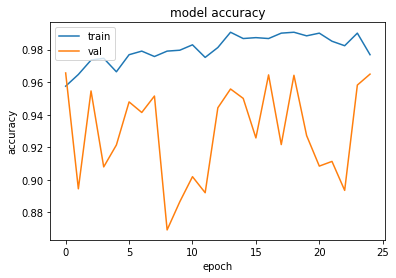

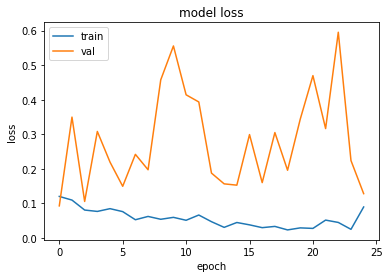

In [56]:
plt.figure()
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
# Loads the weights
model.load_weights(CHECKPOINT_PATH+'\chk.h5')

# Re-evaluate the model
loss, acc = model.evaluate(train_generator, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Restored model, val_accuracy: {:5.2f}%".format(100 * acc))

58/58 [==============================] - 17s 291ms/step - loss: 0.2900 - accuracy: 0.8834
Restored model, accuracy: 88.34%
131/131 [==============================] - 6s 42ms/step - loss: 0.0761 - accuracy: 0.9791
Restored model, val_accuracy: 97.91%


#####
Busted af doesnot work

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
y_pred = []
for fpath in train_generator.filenames:
    cur_path = os.path.join(BASE_DIR+"\\"+'stroke-normal_dataset_processed\Train',fpath)
    im = prepareDataset(cur_path)
    val = model.predict(im,verbose = 0)
    if(val<0.5):
        y_pred.append(0)
    else:
        y_pred.append(1)
os.system('cls')
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))
print('Classification Report')
target_names = ['droopy', 'normal']
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

1/1 [==============================] - 0s 19ms/step
Confusion Matrix
[[737 185]
 [ 19 903]]
Classification Report
              precision    recall  f1-score   support

      droopy       0.97      0.80      0.88       922
      normal       0.83      0.98      0.90       922

    accuracy                           0.89      1844
   macro avg       0.90      0.89      0.89      1844
weighted avg       0.90      0.89      0.89      1844



In [234]:
counter = 0
for i in range(len(train_generator.labels[:922])):
    if train_generator.labels[i] == y_pred[i]:
        continue
    else:
        counter+=1
print('Number of misclassified images: ', counter)

Number of misclassified images:  258


In [137]:
train_generator.labels[5]

0

In [160]:
norml = [x for x in preds if x>0.5]
droo = [x for x in preds if x<0.5]
len(droo)

152

## Prediction

### By Dataset

In [18]:
def showPlot():
    pass

### by manual

In [187]:
np.unique(validation_generator.labels, return_counts=True)

(array([0, 1]), array([ 102, 4069], dtype=int64))

1/1 [==============================] - 0s 104ms/step


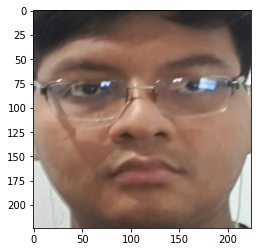

Droopy Confidence 84.367870 %


In [66]:
# convert one face into samples
# filepath = os.path.join(BASE_DIR+"\\"+'stroke-normal_dataset_processed\Train\droopy\\a-39-215x300.jpg')
filepath = os.path.join(BASE_DIR+'\\622351.jpg')
im = prepareImg(filepath)
plt.imshow(im[0])
plt.show()
prediction = model.predict(im,verbose = 0)
if (prediction[0]< 0.5):
    # print("Droopy Confidence {:02f}".format(prediction[0][0]))
    print("Droopy Confidence {:02f} %".format((1-prediction[0][0]*2)*100))
else:
    # print("Droopy Confidence {:02f}".format(prediction[0][0]))
    print("Normal Confidence {:02f} %".format((prediction[0][0])*100))

## Using Face Landmark

In [ ]:
import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')
cap = cv2.VideoCapture(0)

## reference

In [ ]:
# Load saved model
# classifier_model=tf.keras.models.load_model('face_classifier_model.h5')

# dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

# # Label names for class numbers
# person_rep={0:'Lakshmi Narayana',
#  1: 'Vladimir Putin',
#  2: 'Angela Merkel',
#  3: 'Narendra Modi',
#  4: 'Donald Trump',
#  5: 'Xi Jinping'}

# file_path=input("Path to image with file size < 100 kb ? ")

# img=cv2.imread(file_path)
# if img is None or img.size is 0 :
#   print("Please check image path or some error occured")
#   exit()

# persons_in_img=[]
# gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # Detect Faces
# rects=dnnFaceDetector(gray,1)
# left,top,right,bottom=0,0,0,0
# for (i,rect) in enumerate(rects):
#   # Extract Each Face
#   left=rect.rect.left() #x1
#   top=rect.rect.top() #y1
#   right=rect.rect.right() #x2
#   bottom=rect.rect.bottom() #y2
#   width=right-left
#   height=bottom-top
#   img_crop=img[top:top+height,left:left+width]
#   cv2.imwrite(os.getcwd()+'/crop_img.jpg',img_crop)

#   # Get Embeddings
#   crop_img=load_img(os.getcwd()+'/crop_img.jpg',target_size=(224,224))
#   crop_img=img_to_array(crop_img)
#   crop_img=np.expand_dims(crop_img,axis=0)
#   crop_img=preprocess_input(crop_img)
#   img_encode=vgg_face(crop_img)

#   # Make Predictions
#   embed=K.eval(img_encode)
#   person=classifier_model.predict(embed)
#   name=person_rep[np.argmax(person)]
#   os.remove(os.getcwd()+'/crop_img.jpg')
#   cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
#   img=cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
#   img=cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
#   persons_in_img.append(name)
# # Save images with bounding box,name and accuracy 
# cv2.imwrite(os.getcwd()+'/recognized_img.jpg',img)

# #Person in image
# print('Person(s) in image is/are:')
# print(persons_in_img)

# plt.figure(figsize=(8,4))
# plt.imshow(img[:,:,::-1])
# plt.axis('off')
# plt.show()